# Deep-Q-Learning

In this notebook I explore the concepts of Deep-Q-Learning by following the papers published DeepMind [V. Mnih et al (2013)](https://arxiv.org/pdf/1312.5602.pdf) and [V. Mnih et al (2015)](https://www.nature.com/articles/nature14236/).

As I'm intrigued by the topic of autonomous driving, the [MIT lecture videos by Lex Fridman](https://deeplearning.mit.edu/) introduced me to the topic of DQL motivated me to take a deep dive and get familiar with its concepts.

### !!!This is still a work in progress!!!

In [3]:
import gym
import numpy as np
import random

import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, Flatten, Dense

## Preview of the game

Use **left** and **right arrows** to move the spaceship sideways and the **space bar** to use the main cannon and shoot the aliens!

If you want to move to the left/right and shoot simultaneously then use **s/d**.

As you play, the `PlayPlot` function (marked deprecated) will plot the immediate award for the actions you take. For this uncomment the callback call in the `play` function. 

In [3]:
import pygame
from gym.utils.play import play, PlayPlot

def compute_metrics(obs_t, obs_tp, action, reward, terminated, truncated, info):
    return [reward, np.linalg.norm(action)]

plotter = PlayPlot(
    compute_metrics,
    horizon_timesteps=200,
    plot_names=["Immediate Rew.", "Action Magnitude"]
)

my_env = gym.make("SpaceInvaders-v4", render_mode="rgb_array")
mapping = {(pygame.K_SPACE,): 1, (pygame.K_RIGHT,): 2, (pygame.K_LEFT,): 3, (pygame.K_d,): 4, (pygame.K_s,): 5}
play(my_env, keys_to_action=mapping) #, callback=plotter.callback)

/home/hare/.local/lib/python3.10/site-packages/gym/utils/play.py:322: DeprecationWarning: WARN: `PlayPlot` is marked as deprecated and will be removed in the near future.
  deprecation(
A.L.E: Arcade Learning Environment (version 0.8.0+919230b)
[Powered by Stella]
ERROR: PlayableGame wrapper works only with rgb_array and rgb_array_list render modes, but your environment render_mode = None.
/home/hare/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


## Some random action taken

In [ ]:
import gym
env = gym.make("SpaceInvaders-v4", render_mode="human")
observation, info = env.reset(seed=42)
for _ in range(1000):
    action = choose_action(env, observation, 1)
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()
env.close()

## Starting to define some functions

In [4]:
def choose_action (env, obs, eps):
    # get a random number
    random_number = np.random.rand()
    
    if random_number < eps:
        # we explore
        action = env.action_space.sample()
        
    else:
        # we choose the action yielding the highest reward according to our model
        action = env.action_space.sample()
    
    return action
    

For the first attempt we'll use the architecture of the neural network described on page 6 in [Volodymir Mnih et al (2013)](https://arxiv.org/pdf/1312.5602.pdf).

### Preprocess function $\phi$

Since it will be computationally more demanding working with the raw $210 \times 160$ pixel frames, we'll apply a preprocess function $\phi$ to the frames before forwarding them to the neural network. The preprocess function will do the following
- for a single frame we take the maximum value for each pixel color value and the previous frame (removes flickering in original paper, but we'll use the `ALE/SpaceInvaders-v5` environment which has a frameskip=5 which removes the flickering of the misiles)
- the frames will be converted from RGB representation into gray-scale
- the frames will be resized to $110 \times 84$ images
- the playing area is cropped out so we have a final $84 \times 84$ frame (this is done in, but I might skip this step in this notebook [Volodymir Mnih et al (2013)](https://arxiv.org/pdf/1312.5602.pdf))
- the last 4 frames from a sequence will be modified as explained and stacked to form a $84 \times 84 \times 4$ input for the agent

So, to preprocess our input for the neuarl network, we'll need a function $\phi$ that will take the previous processed sequence $\phi_t$ and new obtained frame $x_{t+1}$ and combine them to a new processed sequence as follows

$$\phi: \phi_t, x_{t+1} \longrightarrow \phi_{t+1}$$

In [5]:
def initialize_state (env, curr_raw_obs):
    """
    Initializes the first state of an episode with the first 4 frames.
    Args:
        env: Atari games gym environment,
        cur_obs: first/current observation gained from reseting the environment
    Returns:
        a 84x84x4 input for our NN consisting of 4 preprocessed frames
    """
    curr_obs = preprocess_input(curr_raw_obs)
    processed = [curr_obs]
    
    for i in range(3):
        curr_action = choose_action(env, curr_obs, eps)
        new_raw_obs = my_env.step(curr_action)[0]
        new_obs = preprocess_input(new_raw_obs, curr_raw_obs, curr_state=processed[-1]) 
        processed.append(new_obs)
        
        curr_raw_obs = new_raw_obs
        
    return processed[-1]

In [7]:
def preprocess_input (new_raw_obs, curr_raw_obs=tf.zeros([0, 0]), curr_state=tf.zeros([0, 0])):
        # define a preprocess function for the frames recieving from the Atari games
        # we'll follow again the preprocess function proposed by Volodymir Mnih et al (2013)
        """
        Args:
            cur_state: processed 4 frames with shape (84, 84, 4)
            curr_raw_obs: previous raw frame with shape (210, 160, 3)
            new_raw_obs: new raw frame with shape (210, 160, 3)
        Returns:
            processed new state consisting of last 4 frames with shape (84, 84, 4)
        """
        
        if curr_state.shape != (0, 0):
            ## drop out the oldest frame
            if curr_state.shape[2] > 3:
                prev_state = curr_state[::, ::, 1:]
            else:
                prev_state = curr_state
                
            ## encode new frame with previous one
            
            #to_process = np.stack((curr_raw_obs, new_raw_obs), axis=-1)
            #to_process = np.max(to_process, axis=-1)

            ## process new frame

            processed_fr = tf.image.rgb_to_grayscale(curr_raw_obs)
            processed_fr = tf.image.crop_to_bounding_box(processed_fr, 34, 0, 160, 160)
            processed_fr = tf.image.resize(processed_fr, [84, 84], method='bilinear')
            processed_fr = tf.cast(processed_fr, tf.uint8)
            
            processed_state = tf.concat([prev_state, processed_fr], -1)


            return processed_state
        
        else:            
            ## process new raw frame
        
            processed_fr = tf.image.rgb_to_grayscale(new_raw_obs)
            processed_fr = tf.image.crop_to_bounding_box(processed_fr, 34, 0, 160, 160)
            processed_fr = tf.image.resize(processed_fr, [84, 84], method='bilinear')
            processed_fr = tf.cast(processed_fr, tf.uint8)
            
            return tf.expand_dims(processed_fr[::, ::, -1],axis=-1)

### Testing the preprocess function $\phi$

In [203]:
## get some observations to test the preprocess function
## first 45 memory entries are before the game starts

memory_raw_frames = []
memory_processed = []

env = gym.make("ALE/SpaceInvaders-v5", render_mode="rgb_array")
curr_raw_obs, info = env.reset(seed=42)
preprocessed = initialize_state(env, curr_raw_obs)
memory_processed.append(preprocessed)

memory_raw_frames.append(curr_raw_obs)
for _ in range(500):
    action = choose_action(env, curr_raw_obs, 1)
    new_raw_obs, reward, terminated, truncated, info = env.step(action)
    
    preprocessed = preprocess_input(new_raw_obs, curr_raw_obs, memory_processed[-1])
    memory_processed.append(preprocessed)
    
    curr_raw_obs = new_raw_obs
    
    memory_raw_frames.append(curr_raw_obs)

    if terminated or truncated:
        observation, info = env.reset()
env.close()

In [204]:
import numpy as np
import matplotlib.pyplot as plt

def plot_raw_frames(frames):

    fig = plt.figure(figsize=(10, 10))
    columns = 4
    rows = 1
    for i in range(1, columns*rows +1):
        img = frames[i]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()
    
def plot_processed_frames(frames):

    fig = plt.figure(figsize=(10, 10))
    columns = 4
    rows = 1
    for i in range(1, columns*rows +1):
        img = frames[i]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img[::, ::, 2])
    plt.show()

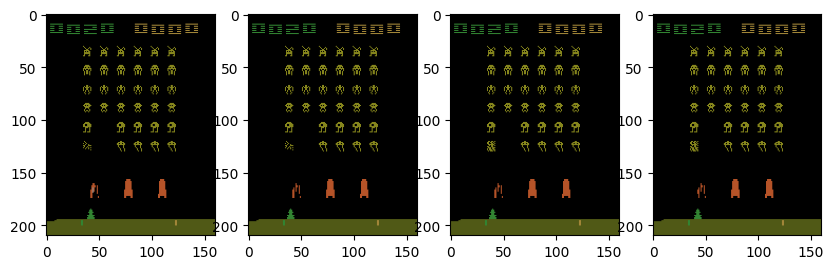

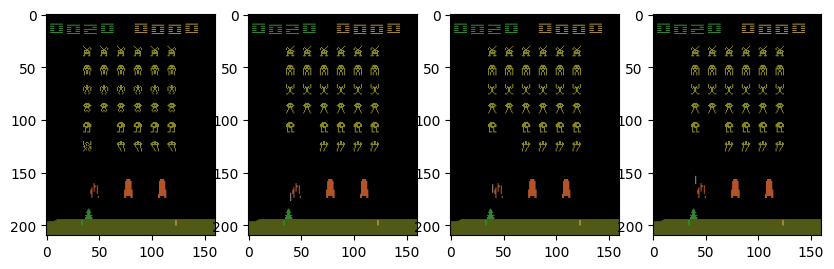

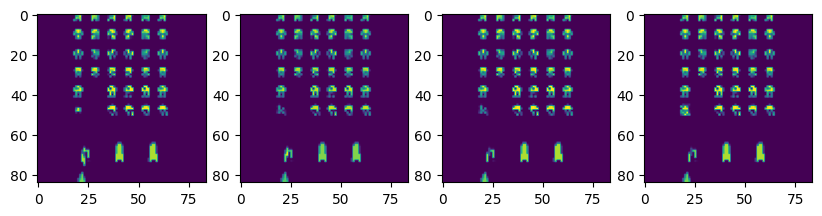

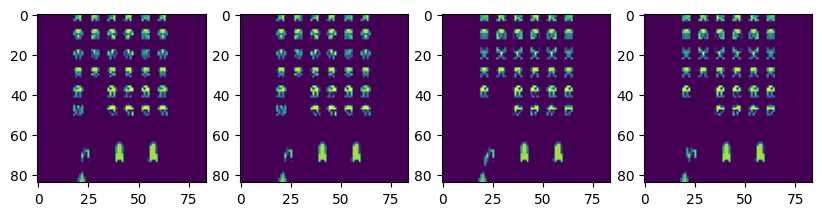

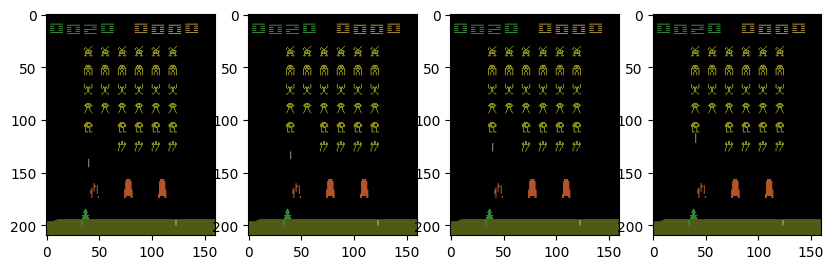

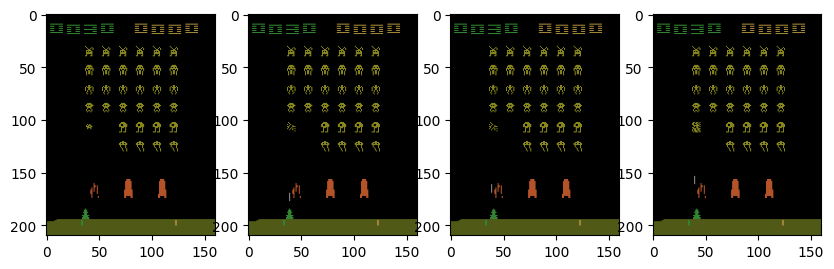

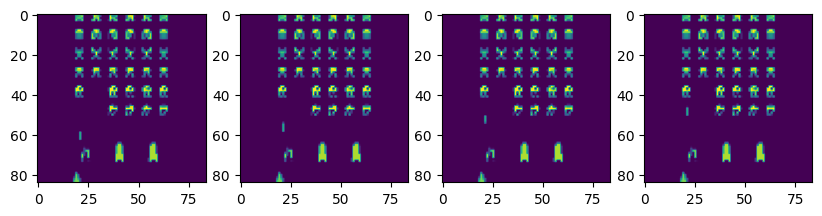

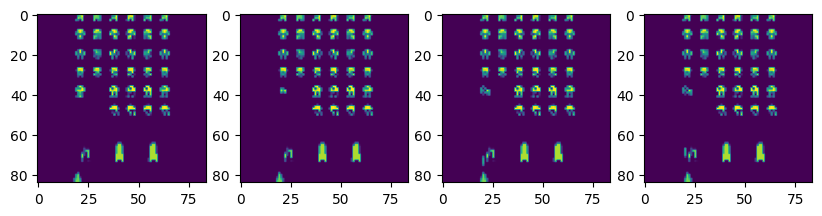

In [205]:
plot_raw_frames(memory_raw_frames[130:])
plot_raw_frames(memory_raw_frames[135:])
plot_processed_frames(memory_processed[131:])
plot_processed_frames(memory_processed[136:])
plot_raw_frames(memory_raw_frames[140:])
plot_raw_frames(memory_raw_frames[145:])
plot_processed_frames(memory_processed[141:])
plot_processed_frames(memory_processed[146:])

### Defining the agent

In [8]:
def agent (obs_shape, action_shape, learning_rate):
    # define a Sequential CNN using Keras predefined layers
    # Here we'll use the same architecture as in Volodymir Mnih et al (2015)
    
    # need to check if I can use a keras model or I need to define something more custom for DQN
    model = keras.Sequential()
    model.add(Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4), padding="same", activation="relu", input_shape=(84, 84, 4)))
    model.add(Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same", activation="relu", input_shape=(84, 84, 4)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu", input_shape=(84, 84, 4)))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dense(action_shape, activation="linear"))

    model.compile(loss=keras.losses.Huber(), optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])        
    
    return model


### Replay memory

The replay memory D stores following information (called *transition*) every step

$$\left( \phi_t, \ a_t, \ r_t, \ \phi_{t+1} \right) \longrightarrow D$$

where
- $\phi_t$ is the preprocessed sequence including the frame at time step $t$
- $a_t$ is the action taken at time step $t$
- $r_t$ is the reward gained at time step $t$ after taking action $a_t$ in state $\phi_t$ $t$
- $\phi_{t+1}$ is the preprocessed sequence including the new state we reached after taking action $a_t$

In [9]:
class replay_memory:
    def __init__(self, capacity, minibatch_size):
        self.capacity = capacity
        self.memories = []
        self.minibatch_size = minibatch_size
        
    def store_transition(self, curr_state, curr_action, reward, new_state, lives):
        # store transition in replay_memory
        self.memories.append([curr_state, curr_action, reward, new_state, lives])
        if (len(self.memories) > self.capacity):
            self.memories.pop(0)
    def sample_minibatch(self):
        # sample a minibatch of transition from replay_memory
        return random.sample(self.memories, self.minibatch_size)
    
    def get_memories(self):
        return self.memories
    
    def get_count_of_memories(self):
        return len(self.memories)

In [18]:
def update_step(replay_memory, main_model, target_model):
    # sample minibatch of transitions
    minibatch = replay_memory.sample_minibatch()
    target_q = []
    X = []
    
    # for each transition we need a target value Q
    for (idx, (curr_state, curr_action, reward, new_state, lives)) in enumerate(minibatch):
        X.append(curr_state)
        if lives == 0:
            target_q.append(reward)
        else:
            new_state = tf.expand_dims(new_state, axis=0)
            target_pred = max(target_model.predict(new_state, verbose=0)[0])
            target_pred = np.repeat(target_pred, action_shape)
            target_q.append(reward + discount * target_pred)
            
    # update the weights of the main model with target values Q
    main_model.fit(x=np.array(X), y=np.array(target_q), epochs=1, verbose=2)
    
    
    

In [12]:
my_env = gym.make("SpaceInvaders-v4",render_mode="rgb_array")
obs_shape = my_env.observation_space.shape
action_shape = my_env.action_space.n

memory_size = 1000
num_of_episodes = 1
minibatch_size = 5 #32
update_target_freq = 5    ## update target NN every 5 parameter updates (steps)
discount = 0.99
action_repeat = 4         ## repeat chosen action 4 times
update_main_freq = 4      ## SGD update main NN after 4 chosen actions
learning_rate = 0.001
grad_mom = 0.95
sq_grad_mom = 0.95
min_sq_grad = 0.01
eps = 1

warm_up = 4

A.L.E: Arcade Learning Environment (version 0.8.0+919230b)
[Powered by Stella]


## Training the model with the Deep-Q-learning Algorithm

Training details:
- We will follow [V. Mnih et al (2015)](https://www.nature.com/articles/nature14236/) and normalize the positive, neutral and negative rewards to 1, 0, -1 respectively

In [13]:
def normalize_rewards(rew):
    return 1 if rew > 0 else -1 if rew < 0 else 0    

In [20]:
def train_DQL():
    ## initialize replay memory D
    memories = replay_memory(memory_size, minibatch_size)
    
    ## initialize action-value function Q with random weights
    main_model = agent(obs_shape, action_shape, learning_rate)
    
    ## initialize action-value target function with same weights 
    target_model = agent(obs_shape, action_shape, learning_rate)
    target_model.set_weights(main_model.get_weights())
    
    memory_count = 0
    
    ## start outer loop of the number of episode we'll train the model for
    for episode in range(num_of_episodes):

        ## initialise sequence s1 = {x1} and preprocessed the sequence
        curr_raw_obs, info = my_env.reset()
        curr_state = initialize_state(my_env, curr_raw_obs)
        
        while (info["lives"] > 0):
            
            ## choose an exploration/explotation action 
            curr_action = choose_action(my_env, curr_state, eps)
            
            ## take action
            new_raw_obs, reward, terminated, truncated, info = my_env.step(curr_action)

            reward = normalize_rewards(reward)

            ## create new sequence with new frame
            new_state = preprocess_input(new_raw_obs, curr_raw_obs, curr_state)

            ## store new transition
            memories.store_transition(curr_state, curr_action, reward, new_state, info["lives"])
            memory_count +=1
            
            ## perform weights update
            if memories.get_count_of_memories() > 50:
                update_step(memories, main_model, target_model)

            curr_state = new_state
            curr_raw_obs = new_raw_obs
                
        #print(memory_count)
        return 0 # memories.get_memories()
            

In [21]:
train_DQL()

1/1 - 1s - loss: 10.9077 - accuracy: 0.0000e+00 - 728ms/epoch - 728ms/step
1/1 - 0s - loss: 37.3495 - accuracy: 0.0000e+00 - 40ms/epoch - 40ms/step
1/1 - 0s - loss: 19.9846 - accuracy: 0.0000e+00 - 40ms/epoch - 40ms/step
1/1 - 0s - loss: 1.7913 - accuracy: 0.0000e+00 - 42ms/epoch - 42ms/step
1/1 - 0s - loss: 5.5519 - accuracy: 1.0000 - 41ms/epoch - 41ms/step
1/1 - 0s - loss: 5.8009 - accuracy: 0.0000e+00 - 40ms/epoch - 40ms/step
1/1 - 0s - loss: 5.5454 - accuracy: 0.0000e+00 - 46ms/epoch - 46ms/step
1/1 - 0s - loss: 2.8181 - accuracy: 0.0000e+00 - 41ms/epoch - 41ms/step
1/1 - 0s - loss: 2.9462 - accuracy: 0.0000e+00 - 43ms/epoch - 43ms/step


KeyboardInterrupt: 

<img src="./images/DQL-algorithm-2015.png" alt="dql" width="850"/>